# Import 

In [25]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import qutip as qt
from copy import deepcopy

import experiments as meas
from experiments.MM_dual_rail_base import MM_dual_rail_base
from fitting.fit_display_classes import GeneralFitting
from fitting.wigner import WignerAnalysis

from slab import AttrDict
from experiments import MultimodeStation, CharacterizationRunner, SweepRunner

from job_server import JobClient
from job_server.database import get_database
from job_server.config_versioning import ConfigVersionManager

# Initialize database and config manager
db = get_database()
config_dir = 'D:/python/multimode_expts/configs'
config_manager = ConfigVersionManager(config_dir)

# Initialize job client (handle submitting and waiting for jobs)
client = JobClient()

# Check server health
health = client.health_check()
print(f"Server status: {health['status']}")
print(f"Pending jobs: {health['pending_jobs']}")

user = "seb"
print("Welcome", user)


station = MultimodeStation(
    user=user,
    experiment_name = "250119_qec",
)

USE_QUEUE = True
mm_base_calib = MM_dual_rail_base(station.hardware_cfg, station.soc)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Server status: healthy
Pending jobs: 0
Welcome seb
[STATION] Using main hardware_config version: CFG-HW-20260122-00015
[STATION] Using main multiphoton_config version: CFG-MP-20260121-00001
[STATION] Using main man1_storage_swap version: CFG-M1-20260122-00013
[STATION] Using main floquet_storage_swap version: CFG-FL-20260121-00001
Data, plots, logs will be stored in: D:\experiments\250119_qec
Hardware configs will be read from D:\python\multimode_expts\configs\versions\hardware_config\CFG-HW-20260122-00015.yml
dict_keys(['Pyro.NameServer', 'Qick101'])
QICK running on ZCU216, software version 0.2.291

Firmware configuration (built Tue Oct 15 12:06:51 2024):

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, bl

In [26]:
# Define defaults, smart config preprocessing and post-measurement updates
# =====================================
singleshot_defaults = AttrDict(dict(    
    reps=5000,
    relax_delay=500,
    check_f=False,
    active_reset=False,
    man_reset=False,
    storage_reset=False,
    qubit=0,
    pulse_manipulate=False,
    cavity_freq=4984.373226159381,
    cavity_gain=400,
    cavity_length=2,
    prepulse=False,
    pre_sweep_pulse=None,
    gate_based=True,
    qubits=[0],
)) # Shouldn't be modifying this on the fly!
# You can use kwargs in the run function to override these values



def singleshot_postproc(station, expt):
    expt.analyze(plot=False, station=station, subdir=station.autocalib_path)
    fids = expt.data['fids']
    confusion_matrix = expt.data['confusion_matrix']
    thresholds_new = expt.data['thresholds']
    angle = expt.data['angle']
    print(fids)

    hardware_cfg = station.hardware_cfg
    hardware_cfg.device.readout.phase = [hardware_cfg.device.readout.phase[0] + angle]
    hardware_cfg.device.readout.threshold = thresholds_new
    hardware_cfg.device.readout.threshold_list = [thresholds_new]
    hardware_cfg.device.readout.Ie = [np.median(expt.data['Ie_rot'])]
    hardware_cfg.device.readout.Ig = [np.median(expt.data['Ig_rot'])]
    if expt.cfg.expt.active_reset:
        hardware_cfg.device.readout.confusion_matrix_with_active_reset = confusion_matrix
    else:
        hardware_cfg.device.readout.confusion_matrix_without_reset = confusion_matrix
    print('Updated readout!')

    expt.display(station)

Job submitted: JOB-20260123-00022 (queue position: 1)

[0.1s] Job JOB-20260123-00022: pending

[20.2s] Job JOB-20260123-00022: running
[WORKER] Loading HistogramExperiment from experiments.single_qubit.single_shot
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260123-00022_HistogramExperiment.h5
[WORKER] Running experiment...
 66%|████████████████████████▏            | 3276/5000 [00:06<00:03, 498.89it/s]
[46.5s] Job JOB-20260123-00022: completed
100%|█████████████████████████████████████| 5000/5000 [00:10<00:00, 499.20it/s]
Unrotated:
Ig 52.47835497835498 +/- 27.108307113265447 	 Qg 57.722943722943725 +/- 26.46224568485196 	 Amp g 78.0122809131765
Ie -41.39177489177489 +/- 31.70777801464429 	 Qe -21.456709956709958 +/- 29.73629333392511 	 Amp e 46.62262788451271
Rotated:
Ig -77.98525740342808 +/- 29.45142790903551 	 Qg -10.437424715228872 +/- 23.82696278067073 	 Amp g 78.68062154663627
Ie 45.94825176371613 +/- 35.83680314374999 	 Qe -10.441616067255119 +/- 24.6039400

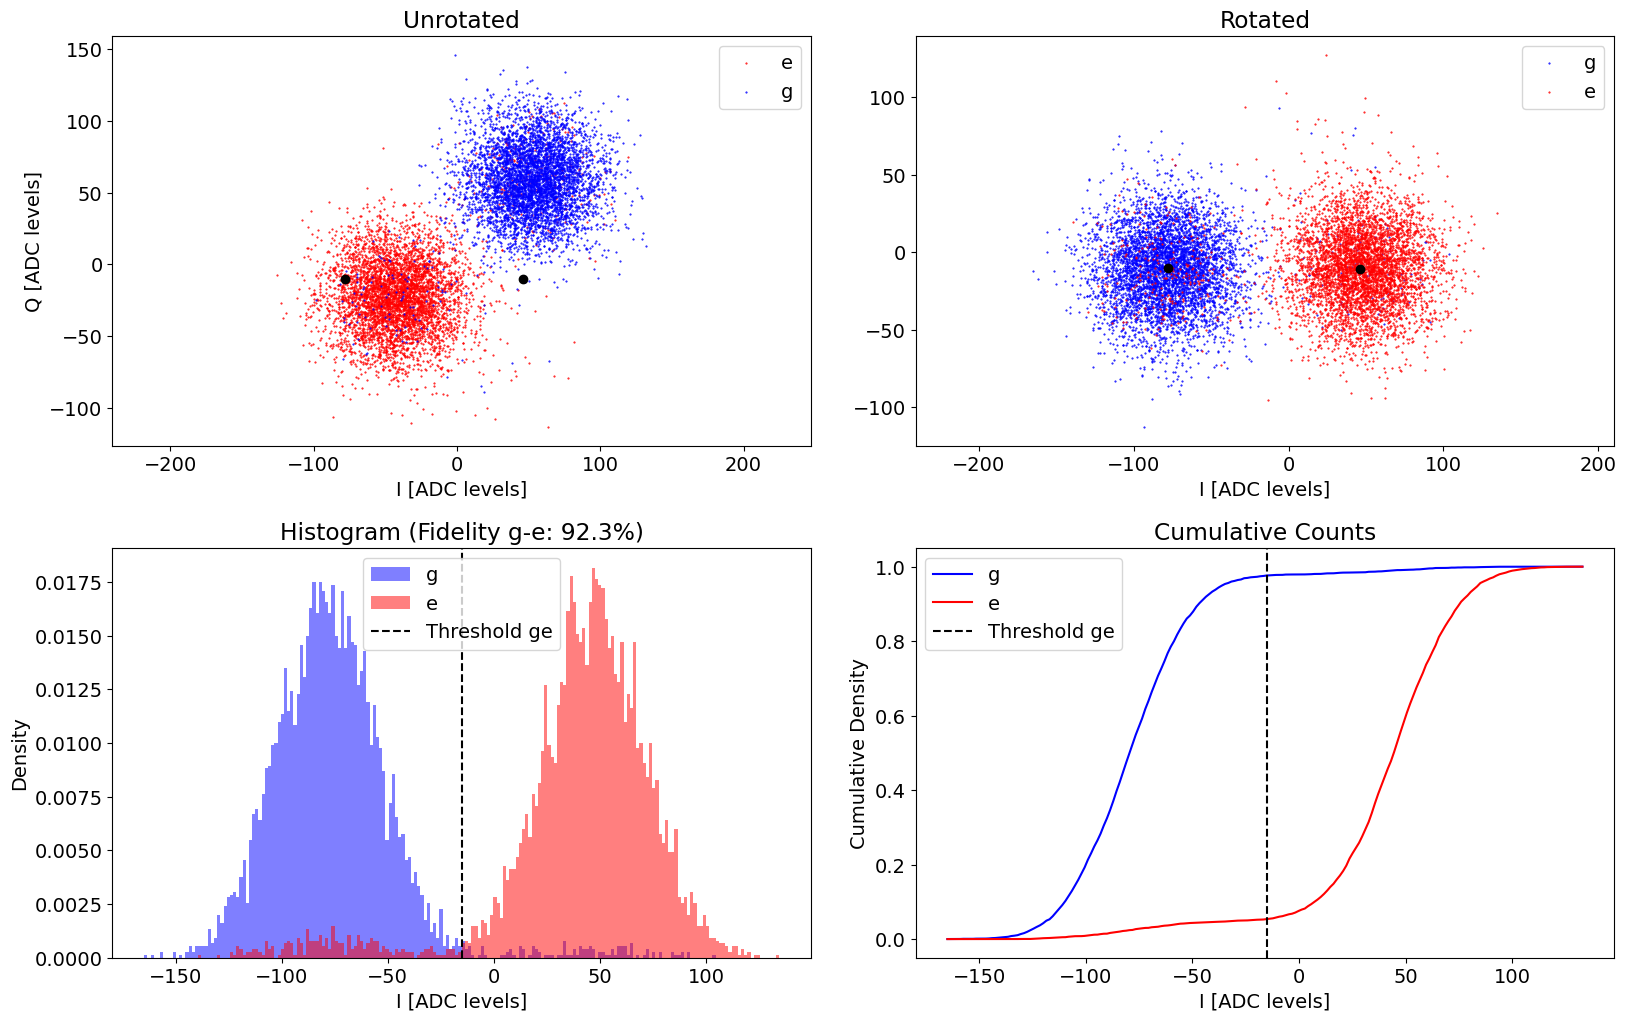

Plot saved to D:\experiments\250119_qec\plots\2026-01-23_10-17-55_histogram.png
Plot reference appended to D:\experiments\250119_qec\logs\2026-01-23.md
ge fidelity (%): 92.26000000000002
rotation angle (deg): 139.8522975988281
threshold ge: -15.234283882573209


In [27]:
single_shot_runner = CharacterizationRunner(
    station = station,
    ExptClass = meas.HistogramExperiment,
    default_expt_cfg = singleshot_defaults,
    postprocessor = singleshot_postproc,
    job_client=client,
    use_queue=USE_QUEUE,
)

single_shot = single_shot_runner.execute(
        go_kwargs=dict(analyze=False, display=False),
        check_f=False,
        active_reset=False, # on recalibration of readout, turn off active reset because it will be wrong for selecting when to apply the qubit pulse
        relax_delay=2000,
        gate_based=False,
    )

In [29]:
# Helper function (kept from original)
def get_storage_mode_parameters(ds_storage, config_thisrun, man_mode_no, stor_mode_no):
    """Get pulse parameters for a given storage mode."""
    stor_name = 'M' + str(man_mode_no) + '-S' + str(stor_mode_no)
    freq = ds_storage.get_freq(stor_name)
    gain = ds_storage.get_gain(stor_name)
    pi_len = ds_storage.get_pi(stor_name)
    h_pi_len = ds_storage.get_h_pi(stor_name)
    flux_low_ch = config_thisrun.hw.soc.dacs.flux_low.ch
    flux_high_ch = config_thisrun.hw.soc.dacs.flux_high.ch
    ch = flux_low_ch if freq < 1000 else flux_high_ch

    mm_base_dummy = MM_dual_rail_base(config_thisrun, soccfg=station.soc)
    prep_man_pi = mm_base_dummy.prep_man_photon(man_mode_no)
    prepulse = mm_base_dummy.get_prepulse_creator(prep_man_pi).pulse.tolist()
    postpulse = mm_base_dummy.get_prepulse_creator(prep_man_pi[-1:-3:-1]).pulse.tolist()

    return freq, gain, pi_len, h_pi_len, ch, prepulse, postpulse


# Configuration defaults for error amplification
error_amp_stor_defaults = AttrDict(dict(
    reps=50,
    rounds=1,
    qubit=0,
    qubits=[0],
    n_start=0,
    n_step=3,
    n_pulses=15,
    expts=50,
    active_reset=False,
    man_reset=True,
    storage_reset=True,
    relax_delay=2500,
    qubit_state_start='g',
))


def error_amp_stor_preproc(station, default_expt_cfg, man_mode_no=1, stor_mode_no=1, 
                           parameter_to_test='gain', span=None, start=None, **kwargs):
    """Preprocessor for error amplification storage."""
    expt_cfg = deepcopy(default_expt_cfg)
    expt_cfg.update(kwargs)
    
    stor_name = f'M{man_mode_no}-S{stor_mode_no}'
    
    # Get current values
    freq, gain, pi_len, h_pi_len, ch, prepulse, postpulse = get_storage_mode_parameters(
        station.ds_storage, station.hardware_cfg, man_mode_no, stor_mode_no
    )

    print('station len pi:', pi_len)




    if qubit_start == 'e':
        freq += station.hardware_cfg.device.manipulate.chi_ge[man_mode_no - 1]
    
    # Set pulse type for storage mode
    expt_cfg.pulse_type = ['storage', stor_name, 'pi', 0]
    expt_cfg.parameter_to_test = parameter_to_test
    
    # Set sweep range based on parameter
    if parameter_to_test == 'gain':
        if span is None:
            span = int(gain * 0.3)  # 30% of current gain
        if start is None:
            expt_cfg.start = int(gain - span / 2)

        expt_cfg.step = int(span / (expt_cfg.expts - 1))
    elif parameter_to_test == 'frequency':
        if span is None:
            span = 0.15  # MHz
        if start is None:
            expt_cfg.start = freq - span / 2
        expt_cfg.step = span / (expt_cfg.expts - 1)
    
    print(f'Error amp ({parameter_to_test}) for {stor_name}: center={freq if parameter_to_test=="frequency" else gain}, span={span}')
    
    return expt_cfg

# def error_amp_stor_postproc(station, expt, man_mode_no=1, stor_mode_no=1, parameter_to_test='gain'):
#     """Postprocessor for error amplification - updates gain or frequency."""
#     stor_name = f'M{man_mode_no}-S{stor_mode_no}'
    
    # Analyze with state_fin='e'
    # expt.analyze(state_fin='e')
    # expt.analyze(state_fin='e')
    # expt.display()
    
    # Update the appropriate parameter
    # optimal_value = expt.data['fit_avgi'][2]
    
    # if parameter_to_test == 'gain':
    #     station.ds_storage.update_gain(stor_name, int(optimal_value))
    #     print(f'Updated gain for {stor_name}: {int(optimal_value)}')
    # if parameter_to_test == 'frequency':
    #     station.ds_storage.update_freq(stor_name, optimal_value)
    #     print(f'Updated frequency for {stor_name}: {optimal_value:.4f} MHz')

# Create runner (we'll pass parameter_to_test at runtime)
# error_amp_stor_runner = CharacterizationRunner(
#     station=station,
#     ExptClass=meas.single_qubit.error_amplification.ErrorAmplificationExperiment,
#     default_expt_cfg=error_amp_stor_defaults,
#     preprocessor=error_amp_stor_preproc,
#     # postprocessor=error_amp_stor_postproc,
#     job_client=client,
#     use_queue=USE_QUEUE,
# )

In [36]:
expts_to_run = {
                #storage
                'stor_modes': [1], # [1,2, .., 7] if also want to run  all modes 
                }
man_mode_no = 1

In [43]:
length_vectors = {}
gain_vectors = {}
freq_vectors = {}
num_pts = 2
qubit_states = ['g', 'e']

for stor_mode_no in expts_to_run.get('stor_modes', [1]):
    freq, gain, pi_len, h_pi_len, ch, prepulse, postpulse = get_storage_mode_parameters(
        station.ds_storage, station.hardware_cfg, man_mode_no, stor_mode_no
    )
    len_min = (pi_len * 0.7)
    len_max = (pi_len * 1.2)

    # len_min = (pi_len * 0.3)
    # len_max = (pi_len * 1.2)
    
    # Initialize nested dicts for this mode
    length_vectors[stor_mode_no] = {}
    gain_vectors[stor_mode_no] = {}
    freq_vectors[stor_mode_no] = {}
    
    for qubit_state in qubit_states:
        length_vectors[stor_mode_no][qubit_state] = np.linspace(len_max, len_min, num=num_pts)
        gain_vectors[stor_mode_no][qubit_state] = gain * pi_len / length_vectors[stor_mode_no][qubit_state]

        freq_vectors[stor_mode_no][qubit_state] = np.linspace(freq, freq, num=num_pts)
        if qubit_state == 'e':
            freq_vectors[stor_mode_no][qubit_state] += station.hardware_cfg.device.manipulate.chi_ge[man_mode_no - 1]
    
    print(f"Storage mode {stor_mode_no}:")
    print("Length vectors:", length_vectors[stor_mode_no])
    print("Gain vectors:", gain_vectors[stor_mode_no])
    print("Frequency vectors:", freq_vectors[stor_mode_no])

Storage mode 1:
Length vectors: {'g': array([2.35017751, 1.37093688]), 'e': array([2.35017751, 1.37093688])}
Gain vectors: {'g': array([2835., 4860.]), 'e': array([2835., 4860.])}
Frequency vectors: {'g': array([352.81020738, 352.81020738]), 'e': array([353.09042471, 353.09042471])}


In [45]:
qubit_start = 'e'

2.3501775090469197
Running error amp (frequency) for M1-S1
Testing pi length: 2.3501775090469197 us, gain: 2835.0, frequency: 353.09042470983235 MHz
station len pi: 2.3501775090469197
Error amp (frequency) for M1-S1: center=353.3706420379947, span=0.2
Job submitted: JOB-20260123-00059 (queue position: 1)

[0.1s] Job JOB-20260123-00059: pending

[2.1s] Job JOB-20260123-00059: running
[WORKER] Loading ErrorAmplificationExperiment from experiments.single_qubit.error_amplification
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260123-00059_ErrorAmplificationExperiment.h5
[WORKER] Running experiment...
cfg at start of acquire {'reps': 50, 'rounds': 1, 'qubit': 0, 'qubits': [0], 'n_start': 0, 'n_step': 3, 'n_pulses': 10, 'expts': 50, 'active_reset': False, 'man_reset': True, 'storage_reset': True, 'relax_delay': 2500, 'qubit_state_start': 'e', 'analyze': False, 'display': False, 'pulse_type': ['storage', 'M1-S1', 'pi', 0], 'parameter_to_test': 'frequency', 'start': 353.270

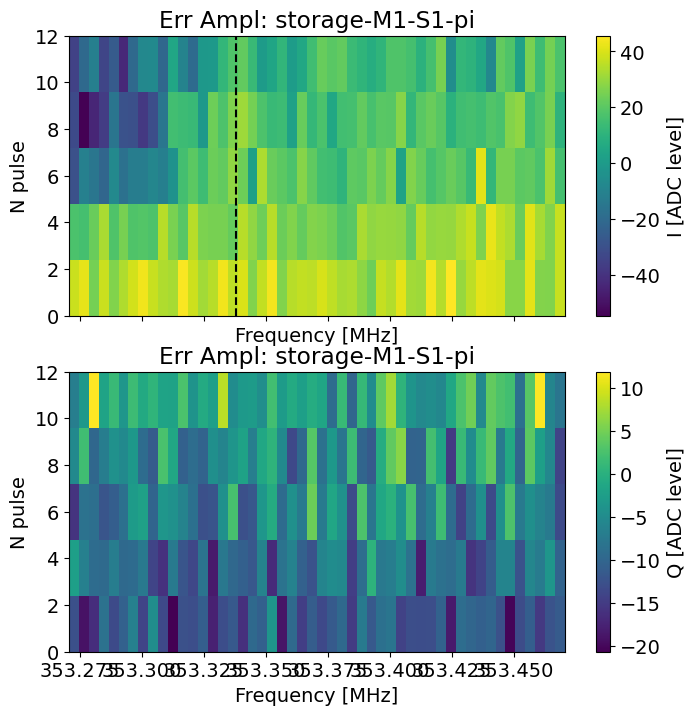

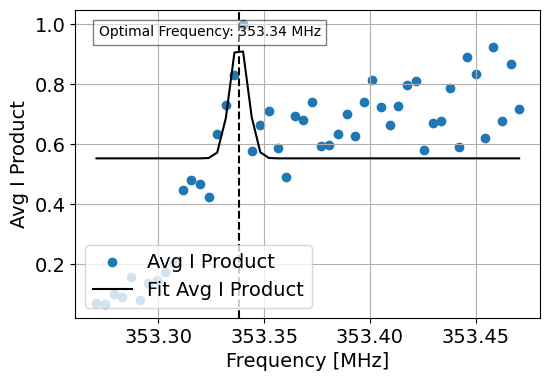

Updated frequency for M1-S1: 353.3380 MHz
Running error amp (gain) for M1-S1
station len pi: 2.3501775090469197
Error amp (gain) for M1-S1: center=2835, span=1190
Job submitted: JOB-20260123-00060 (queue position: 1)

[0.1s] Job JOB-20260123-00060: pending

[2.1s] Job JOB-20260123-00060: running
[WORKER] Loading ErrorAmplificationExperiment from experiments.single_qubit.error_amplification
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260123-00060_ErrorAmplificationExperiment.h5
[WORKER] Running experiment...
cfg at start of acquire {'reps': 50, 'rounds': 1, 'qubit': 0, 'qubits': [0], 'n_start': 0, 'n_step': 3, 'n_pulses': 10, 'expts': 50, 'active_reset': False, 'man_reset': True, 'storage_reset': True, 'relax_delay': 2500, 'qubit_state_start': 'e', 'analyze': False, 'display': False, 'pulse_type': ['storage', 'M1-S1', 'pi', 0], 'parameter_to_test': 'gain', 'start': 2240, 'step': 24}
  0%|                                                    | 0/5 [00:00<?, ?it/s]puls

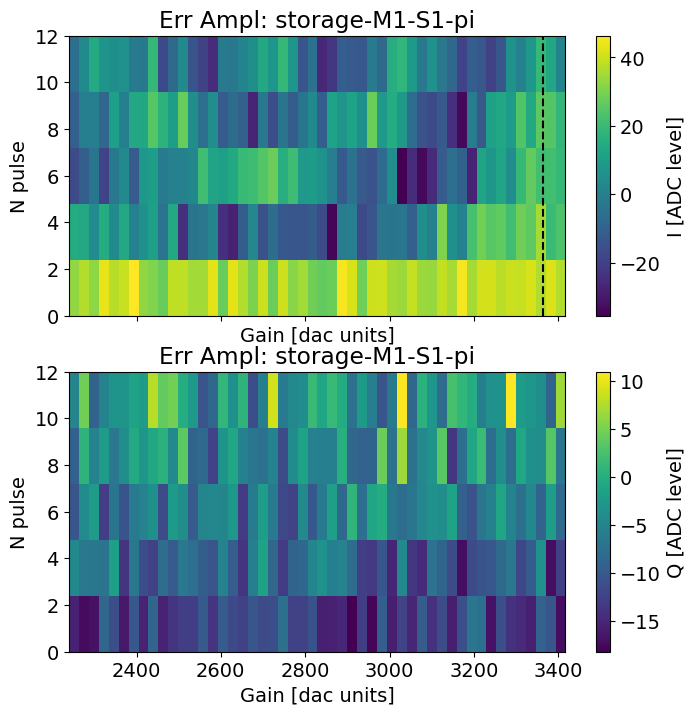

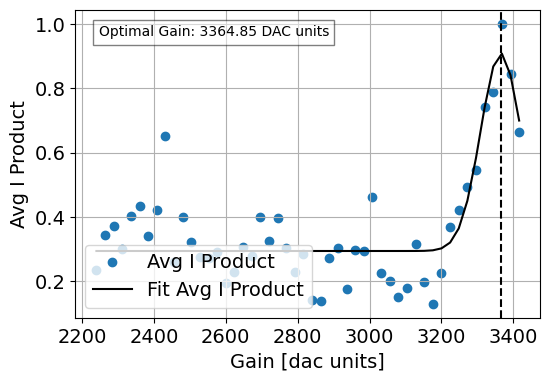

Updated gain for M1-S1: 3364
Running final error amp (frequency) for M1-S1
station len pi: 2.3501775090469197
Error amp (frequency) for M1-S1: center=353.6182460002442, span=0.1
Job submitted: JOB-20260123-00061 (queue position: 1)

[0.1s] Job JOB-20260123-00061: pending

[2.1s] Job JOB-20260123-00061: running
[WORKER] Loading ErrorAmplificationExperiment from experiments.single_qubit.error_amplification
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260123-00061_ErrorAmplificationExperiment.h5
[WORKER] Running experiment...
cfg at start of acquire {'reps': 50, 'rounds': 1, 'qubit': 0, 'qubits': [0], 'n_start': 0, 'n_step': 3, 'n_pulses': 10, 'expts': 50, 'active_reset': False, 'man_reset': True, 'storage_reset': True, 'relax_delay': 2500, 'qubit_state_start': 'e', 'analyze': False, 'display': False, 'pulse_type': ['storage', 'M1-S1', 'pi', 0], 'parameter_to_test': 'frequency', 'start': 353.5682460002442, 'step': 0.0020408163265306124}
  0%|                          

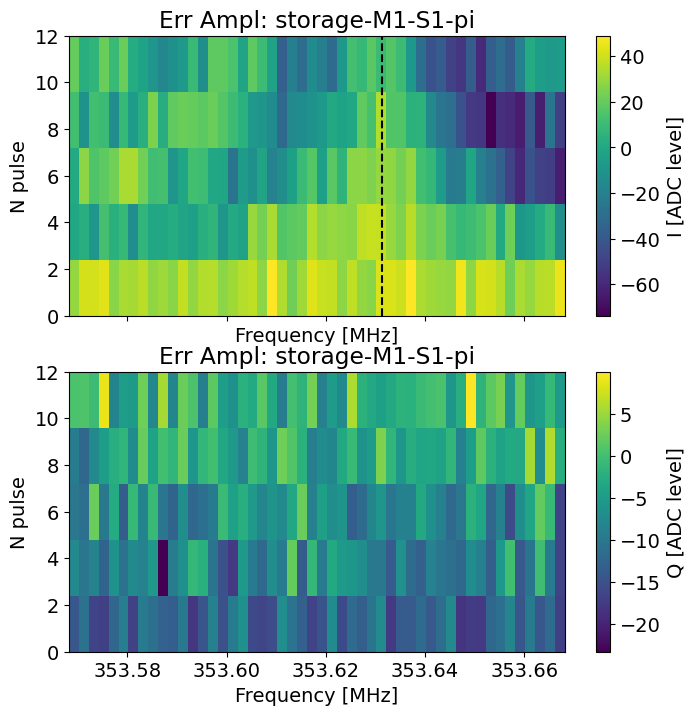

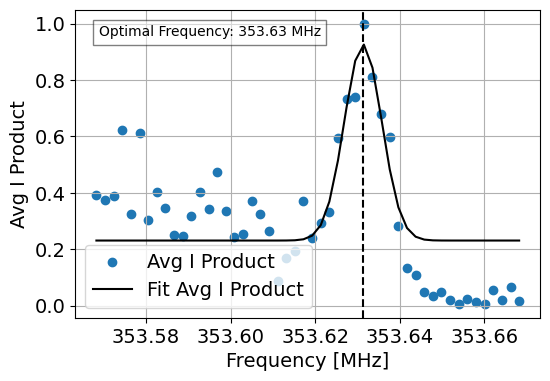

Updated frequency for M1-S1: 353.6313 MHz
1.3709368802773698
Running error amp (frequency) for M1-S1
Testing pi length: 1.3709368802773698 us, gain: 4860.0, frequency: 353.63132094279376 MHz
station len pi: 1.3709368802773698
Error amp (frequency) for M1-S1: center=353.9115382709561, span=0.2
Job submitted: JOB-20260123-00062 (queue position: 1)

[0.1s] Job JOB-20260123-00062: pending

[2.1s] Job JOB-20260123-00062: running
[WORKER] Loading ErrorAmplificationExperiment from experiments.single_qubit.error_amplification
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260123-00062_ErrorAmplificationExperiment.h5
[WORKER] Running experiment...
cfg at start of acquire {'reps': 50, 'rounds': 1, 'qubit': 0, 'qubits': [0], 'n_start': 0, 'n_step': 3, 'n_pulses': 10, 'expts': 50, 'active_reset': False, 'man_reset': True, 'storage_reset': True, 'relax_delay': 2500, 'qubit_state_start': 'e', 'analyze': False, 'display': False, 'pulse_type': ['storage', 'M1-S1', 'pi', 0], 'paramet

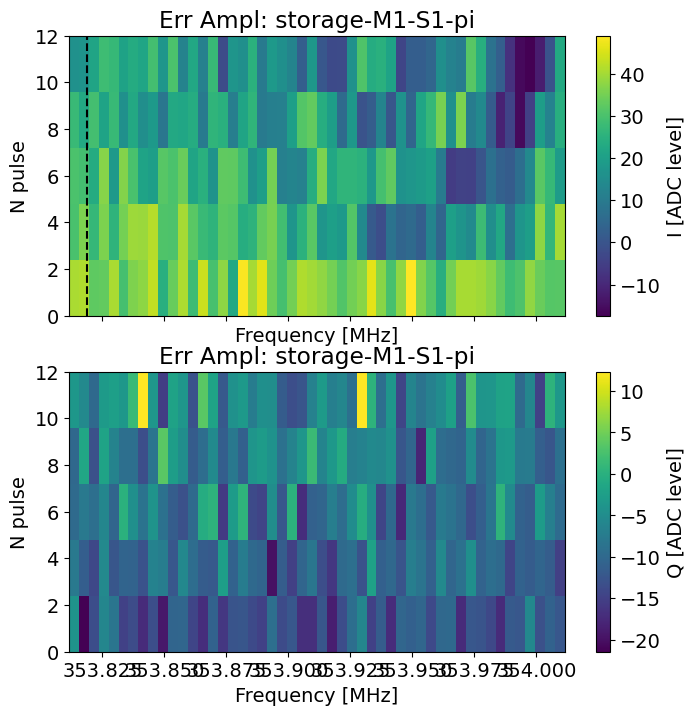

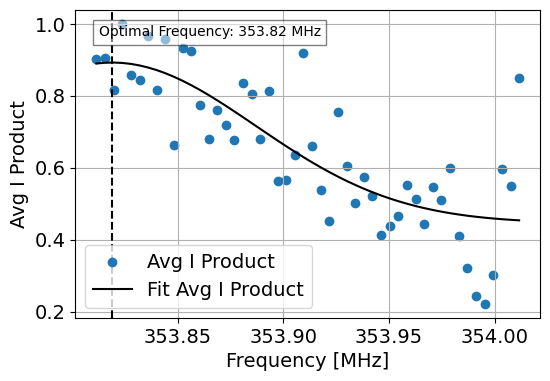

Updated frequency for M1-S1: 353.8190 MHz
Running error amp (gain) for M1-S1
station len pi: 1.3709368802773698
Error amp (gain) for M1-S1: center=4860, span=1190
Job submitted: JOB-20260123-00063 (queue position: 1)

[0.1s] Job JOB-20260123-00063: pending

[2.1s] Job JOB-20260123-00063: running
[WORKER] Loading ErrorAmplificationExperiment from experiments.single_qubit.error_amplification
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260123-00063_ErrorAmplificationExperiment.h5
[WORKER] Running experiment...
cfg at start of acquire {'reps': 50, 'rounds': 1, 'qubit': 0, 'qubits': [0], 'n_start': 0, 'n_step': 3, 'n_pulses': 10, 'expts': 50, 'active_reset': False, 'man_reset': True, 'storage_reset': True, 'relax_delay': 2500, 'qubit_state_start': 'e', 'analyze': False, 'display': False, 'pulse_type': ['storage', 'M1-S1', 'pi', 0], 'parameter_to_test': 'gain', 'start': 4265, 'step': 24}
  0%|                                                    | 0/5 [00:00<?, ?it/s]puls

KeyboardInterrupt: 

In [46]:
# Error Amplification Storage - New Pattern with CharacterizationRunner

# Example execution - gain optimization followed by frequency optimization
for stor_mode_no in expts_to_run.get('stor_modes', [1]):
    stor_name = f'M1-S{stor_mode_no}'

    original_freq, original_gain, original_pi_len, h_pi_len, ch, prepulse, postpulse = get_storage_mode_parameters(
        station.ds_storage, station.hardware_cfg, man_mode_no, stor_mode_no
    )

    # set the pi_length, gain and frequency to be tested
    for idx, pi_len_test in enumerate(length_vectors[stor_mode_no][qubit_start]):
        station.ds_storage.update_pi(stor_name, pi_len_test)
        _idx = idx if idx==0 else idx-1
        station.ds_storage.update_gain(stor_name, gain_vectors[stor_mode_no][qubit_start][idx])  
        station.ds_storage.update_freq(stor_name, freq_vectors[stor_mode_no][qubit_start][_idx]) 
        print(station.ds_storage.get_pi(stor_name)) 

        print(f'Running error amp (frequency) for {stor_name}')
        print(f"Testing pi length: {pi_len_test} us, gain: {gain_vectors[stor_mode_no][qubit_start][idx]}, frequency: {freq_vectors[stor_mode_no][qubit_start][_idx]} MHz")
        # Round 1: Frequency optimization

        error_amp_stor_runner = CharacterizationRunner(
            station=station,
            ExptClass=meas.single_qubit.error_amplification.ErrorAmplificationExperiment,
            default_expt_cfg=error_amp_stor_defaults,
            preprocessor=error_amp_stor_preproc,
            # postprocessor=error_amp_stor_postproc,
            job_client=client,
            use_queue=USE_QUEUE,
        )
        error_amp_freq = error_amp_stor_runner.execute(
            man_mode_no=man_mode_no,
            stor_mode_no=stor_mode_no,
            parameter_to_test='frequency',
            span=0.2,
            n_step=3,
            n_pulses=10,
            analyze=False,
            display=False,
            reps=50,
            qubit_state_start=qubit_start,
        )

        # update frequency based on optimization

        error_amp_freq.analyze(state_fin='e')
        error_amp_freq.display()
        optimal_value_freq = error_amp_freq.data['fit_avgi'][2]
        freq_vectors[stor_mode_no][qubit_start][idx] = optimal_value_freq
        station.ds_storage.update_freq(stor_name, optimal_value_freq)
        print(f'Updated frequency for {stor_name}: {optimal_value_freq:.4f} MHz')

        # Round 2: Gain optimization
        print(f'Running error amp (gain) for {stor_name}')
        error_amp_stor_runner = CharacterizationRunner(
            station=station,
            ExptClass=meas.single_qubit.error_amplification.ErrorAmplificationExperiment,
            default_expt_cfg=error_amp_stor_defaults,
            preprocessor=error_amp_stor_preproc,
            # postprocessor=error_amp_stor_postproc,
            job_client=client,
            use_queue=USE_QUEUE,
        )
        error_amp_gain = error_amp_stor_runner.execute(
            man_mode_no=man_mode_no,
            stor_mode_no=stor_mode_no,
            parameter_to_test='gain',
            span=int(original_gain * 0.35),
            n_step=3,
            n_pulses=10,
            analyze=False,
            display=False,
            reps=50,
            qubit_state_start=qubit_start,
        )

        # update gain based on optimization
        error_amp_gain.analyze(state_fin='e')
        error_amp_gain.display()
        optimal_value_gain = error_amp_gain.data['fit_avgi'][2]
        gain_vectors[stor_mode_no][qubit_start][idx] = optimal_value_gain
        station.ds_storage.update_gain(stor_name, int(optimal_value_gain))
        print(f'Updated gain for {stor_name}: {int(optimal_value_gain)}')


        # Final Round: Frequency optimization
        print(f'Running final error amp (frequency) for {stor_name}')

        error_amp_stor_runner = CharacterizationRunner(
            station=station,
            ExptClass=meas.single_qubit.error_amplification.ErrorAmplificationExperiment,
            default_expt_cfg=error_amp_stor_defaults,
            preprocessor=error_amp_stor_preproc,
            # postprocessor=error_amp_stor_postproc,
            job_client=client,
            use_queue=USE_QUEUE,
        )
        error_amp_freq_final = error_amp_stor_runner.execute(
            man_mode_no=man_mode_no,
            stor_mode_no=stor_mode_no,
            parameter_to_test='frequency',
            span=0.1,
            n_step=3,
            n_pulses=10,
            analyze=False,
            display=False,
            reps=50,
            qubit_state_start=qubit_start,
        )

        # update frequency based on optimization
        error_amp_freq_final.analyze(state_fin='e')
        error_amp_freq_final.display()
        optimal_value_freq_final = error_amp_freq_final.data['fit_avgi'][2]
        freq_vectors[stor_mode_no][qubit_start][idx] = optimal_value_freq_final
        station.ds_storage.update_freq(stor_name, optimal_value_freq_final)
        print(f'Updated frequency for {stor_name}: {optimal_value_freq_final:.4f} MHz')
        

    
    # restore original parameters after length sweep
    station.ds_storage.update_pi(stor_name, original_pi_len)
    station.ds_storage.update_gain(stor_name, original_gain)
    station.ds_storage.update_freq(stor_name, original_freq)
        



Beam splitter rates: {1: array([0.21274989, 0.23209079, 0.25529986, 0.28366652, 0.31912483,
       0.36471409, 0.42549977, 0.51059973, 0.63824966, 0.85099955])}


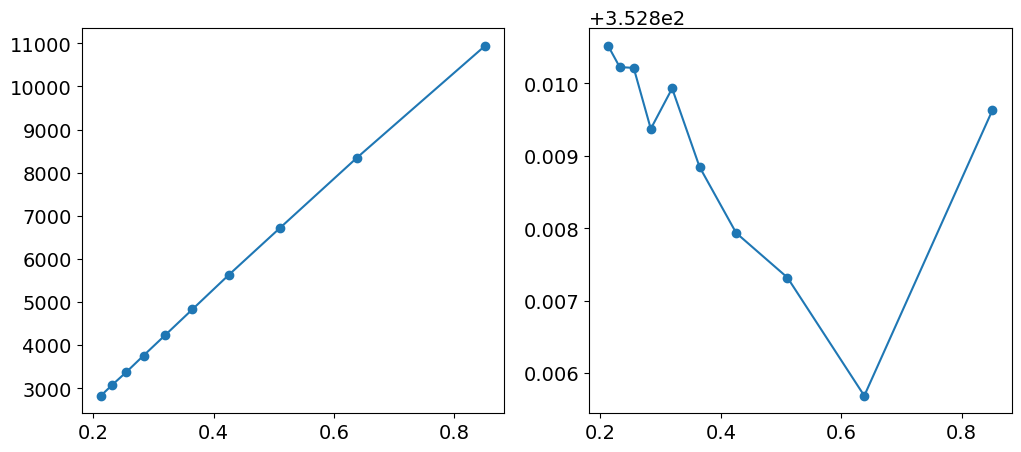

In [ ]:
# from the pulse length we compute the beam-splitter rate and plot is versus gain, same for frequency 

beam_splitter_rates = {}
for stor_mode_no in expts_to_run.get('stor_modes', [1]):
    beam_splitter_rates[stor_mode_no] = 1/(2*length_vectors[stor_mode_no][qubit_start])
    print("Beam splitter rates:", beam_splitter_rates)

fig, ax = plt.subplots(1,2, figsize=(12,5))
for stor_mode_no in expts_to_run.get('stor_modes', [1]):
    ax[0].plot(gain_vectors[stor_mode_no][qubit_start],beam_splitter_rates[stor_mode_no],  marker='o', label=f'Storage Mode {stor_mode_no}')
    ax[1].plot(beam_splitter_rates[stor_mode_no], freq_vectors[stor_mode_no][qubit_start], marker='o', label=f'Storage Mode {stor_mode_no}')